# Orbit Fitting

In [1]:
import warnings 
warnings.filterwarnings('ignore')
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline
import sys
sys.path.append('../code/')
import fit_perturber as fp


import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody

import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from pyia import GaiaData
from sklearn.neighbors import KernelDensity

#%matplotlib notebook
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import GaussianMixture
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt

import emcee
import tqdm
from contextlib import closing
from multiprocessing import Pool
import scipy
import importlib

from skspatial.objects import Line
from skspatial.objects import Points

In [2]:
def plot_pretty(dpi=175, fontsize=15, labelsize=15, figsize=(10, 8), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': False})
    
plot_pretty(fontsize=15, labelsize=15)

In [3]:
phi1_stream_pm_model = np.load('../data/phi1_stream_from_pm_model.npy')
stream_pm10 = np.load('../data/true_pm1_from_model.npy')
spline_pm1 = InterpolatedUnivariateSpline(phi1_stream_pm_model[::10], stream_pm10[::10])
stream_pm20 = np.load('../data/true_pm2_from_model.npy')
spline_pm2 = InterpolatedUnivariateSpline(phi1_stream_pm_model[::10], stream_pm20[::10])

est_track = np.load('../data/gd1_track.npy')
spline_phi2 = UnivariateSpline(phi1_stream_pm_model.reshape(est_track.shape)[::10], 
                                           est_track[::10])

sections = np.arange(-100,15,5)
dm = np.concatenate([[14.7, 14.6, 14.5, 14.45, 14.4, 14.35, 14.3, 14.3], 
                     np.linspace(14.3, 14.6, 9), 
                     [14.71, 14.75, 14.8, 15, 15.2, 15.4]])

spline_dm = UnivariateSpline(sections, dm, k=5)

rv_bonaca_data = fits.open('../data/rv_catalog.fits')[1].data
gd1_rv_bonaca = rv_bonaca_data[rv_bonaca_data.pmmem & rv_bonaca_data.cmdmem & 
                               rv_bonaca_data.vrmem & rv_bonaca_data.fehmem]
gd1_rv_bonaca = gd1_rv_bonaca[gd1_rv_bonaca.phi1.argsort()]

spline_rv_bon = UnivariateSpline(gd1_rv_bonaca.phi1, gd1_rv_bonaca.Vrad, k=1, s = np.inf)


after = GaiaData('../data/member_prob_all.fits')
model_output = after[after.post_member_prob > 0.3]

phi1s = np.linspace(-100, 20, 120)

In [16]:
d = GaiaData('../data/gd1_ps1_with_basic_masks_thin.fits')
d.data

source_id,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,visibility_periods_used,phot_g_mean_mag,phot_g_mean_flux_over_error,phot_bp_mean_mag,phot_bp_mean_flux_over_error,phot_rp_mean_mag,phot_rp_mean_flux_over_error,phot_bp_rp_excess_factor,astrometric_chi2_al,astrometric_n_good_obs_al,objID,raMean,decMean,nDetections,ng,nr,ni,nz,ny,gMeanPSFMag,rMeanPSFMag,iMeanPSFMag,zMeanPSFMag,yMeanPSFMag,gMeanPSFMagErr,rMeanPSFMagErr,iMeanPSFMagErr,zMeanPSFMagErr,yMeanPSFMagErr,sep_arcsec,g_0,r_0,i_0,z_0,y_0,pm_mask,gi_cmd_mask,phi1,phi2,pm_phi1_cosphi2,pm_phi2
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mas / yr,mas / yr
int64,float64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,int64,float64,float64,int16,int16,int16,int16,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64
5707499168266668800,124.34609344941018,-19.671996509666215,0.23908933289662254,0.04781023,-1.627045407691012,0.038337678,2.8751249034893087,0.03121912,0.07823116,-0.11784272,-0.3454113,-0.17714737,-0.38285083,0.2695398,0.3717254,-0.24432613,-0.048542865,22,16.420189,2603.0925,16.666891,329.28018,16.014679,453.14197,1.1893414,584.6626,626,84391243461223933,124.34609539,-19.67199988,80,15,12,24,16,13,16.679800033569336,16.439800262451172,16.354000091552734,16.372600555419922,16.342599868774414,0.0042050001211464405,0.004137000069022179,0.0024840000551193953,0.003889000043272972,0.004776000045239925,0.013801799122398739,16.36138352751732,16.21182930469513,16.185155004262924,16.239893540740013,16.233482979238033,False,False,-99.99998974953799,-9.401555369237643,1.7582442210609377,2.7968191266080042
5714940594243874304,121.03587868896385,-17.94366574903224,0.3223769865071406,0.04870918,-1.9342358955251646,0.046989128,1.5216671309550585,0.03897202,0.05235888,0.075656734,-0.0011952525,-0.14225459,-0.0056617153,0.13800927,0.17716475,-0.24963076,0.23984396,23,16.452152,2206.7917,16.709862,284.7805,16.033773,357.34232,1.1908067,418.0782,443,86461210358997957,121.03588016,-17.94366566,69,10,11,18,18,12,16.717100143432617,16.457500457763672,16.391599655151367,16.3976993560791,16.38719940185547,0.00240899994969368,0.0031109999399632215,0.001227000029757619,0.002572000026702881,0.006430000066757202,0.005048330236075074,16.411197811365128,16.238489046692848,16.229390397667885,16.27020789682865,16.282370947301388,False,False,-99.99998957904452,-5.823224474521122,0.375918811171435,2.432164551112767
3033393083142608384,112.88255235331313,-13.308166225300512,0.4189088151454519,0.21147743,-1.877598028147927,0.18968292,1.1090892820321105,0.18528558,0.122827046,-0.14800596,-0.0108461995,-0.23020032,0.023805281,0.30020782,0.14028092,-0.36037052,-0.17216381,18,18.754494,552.16736,19.24033,32.00037,18.16211,76.3716,1.1899724,325.30243,290,92031128825700538,112.88255253,-13.3081657,47,8,5,11,12,11,19.290800094604492,18.77519989013672,18.507699966430664,18.383699417114258,18.310100555419922,0.009987999685108662,0.023274000734090805,0.008224000222980976,0.01140000019222498,0.01875000074505806,0.001989809338192472,18.18799066543579,17.985641181468964,17.92291885614395,17.924079567193985,17.932183176279068,False,True,-99.99998750084802,3.2922805742688688,-0.03947501399742496,2.180342889025948
3033603231584491136,112.49763946230448,-13.077150305570827,0.4405096706458771,0.43537453,-0.7079983338854163,0.35308954,0.7660376569719846,0.3184226,0.28291208,-0.24630846,-0.14432156,-0.3279706,-0.030186914,0.13491932,0.11588298,-0.39469993,0.010195083,18,19.773771,300.8951,20.64357,14.675906,19.054615,35.72886,1.1418444,306.32825,319,923011249765677

In [68]:
np.sqrt(np.mean(model_output.pm_cov[:, 1,1]))

0.28496430801564243

In [69]:
np.sqrt(np.mean(model_output.pm_cov[:, 0,0]))

0.2101877274949474

<IPython.core.display.Javascript object>


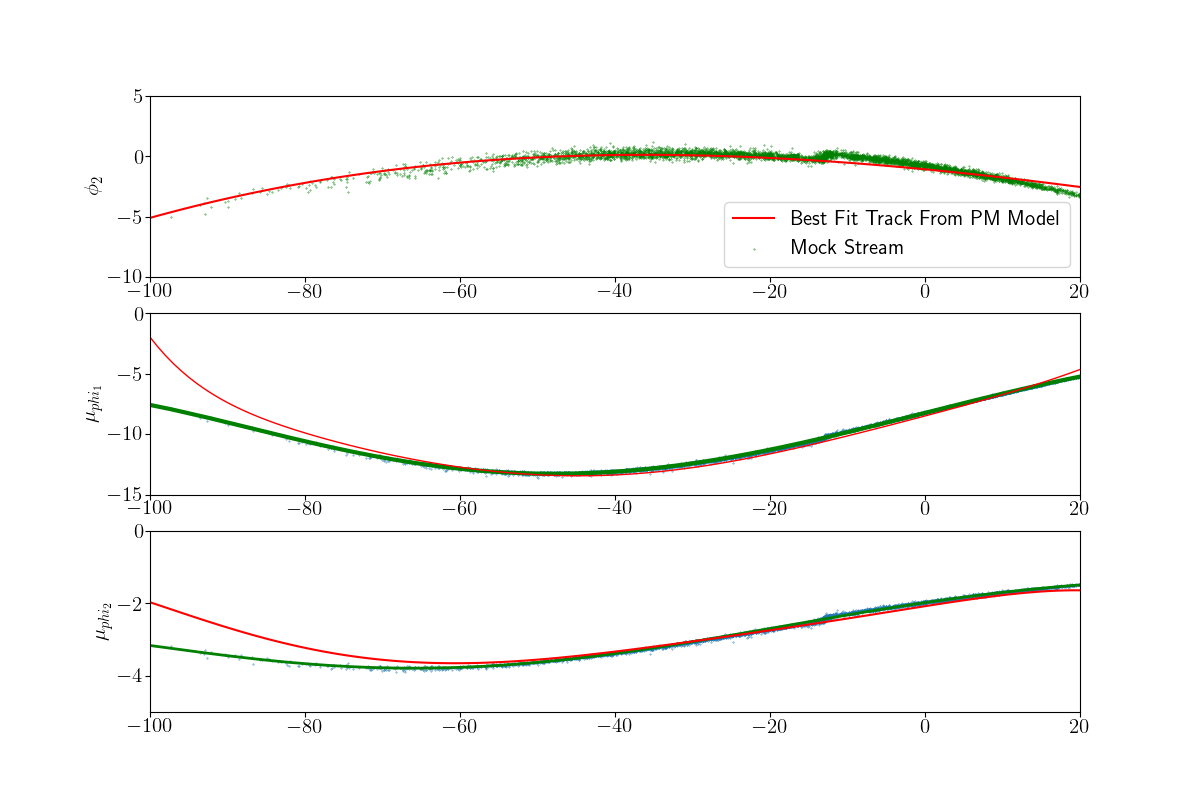

Text(0, 0.5, '$\\mu_{phi_2}$')

In [4]:
# my top choice and the one to use for the spur modeling
#creates the gaps around -20 and -5
df = ms.FardalStreamDF(random_state=np.random.RandomState(42))
#gd1_init = gc.GD1Koposov10(phi1 = -13*u.degree, phi2=-0.2*u.degree, distance=8.73*u.kpc,
#                      pm_phi1_cosphi2=-10.6*u.mas/u.yr,
#                      pm_phi2=-2.52*u.mas/u.yr,
#                     radial_velocity = -185*u.km/u.s)
gd1_init = gc.GD1Koposov10(phi1 = -13*u.degree, phi2=0*u.degree, distance=8.83*u.kpc,
                      pm_phi1_cosphi2=-10.28*u.mas/u.yr,
                      pm_phi2=-2.43* u.mas/u.yr,
                     radial_velocity = -182*u.km/u.s)
rep = gd1_init.transform_to(coord.Galactocentric).data
gd1_w0 = gd.PhaseSpacePosition(rep)
gd1_mass = 5e3 * u.Msun
gd1_pot = gp.PlummerPotential(m=gd1_mass, b=5*u.pc, units=galactic)
mw = gp.MilkyWayPotential(halo={'m': 5.35e11*u.Msun, 'r_s': 15.27*u.kpc})
gen_gd1 = ms.MockStreamGenerator(df, mw, progenitor_potential=gd1_pot)
gd1_stream, gd1_nbody = gen_gd1.run(gd1_w0, gd1_mass,
                                dt=-1 * u.Myr, n_steps=3000)
gd1 = gd1_stream.to_coord_frame(gc.GD1)
sorted_gd1 = gd1[gd1.phi1.argsort()]

spline_pm10 = UnivariateSpline(sorted_gd1.phi1, sorted_gd1.pm_phi1_cosphi2, k=5)
spline_pm20 = UnivariateSpline(sorted_gd1.phi1, sorted_gd1.pm_phi2, k=5)
spline_rv = UnivariateSpline(sorted_gd1.phi1, sorted_gd1.radial_velocity)
spline_dist = UnivariateSpline(sorted_gd1.phi1, sorted_gd1.distance)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(12,8))
ax1.scatter(gd1.phi1.value, gd1.phi2.value, s=0.1, c='g', label='Mock Stream')
ax1.plot(phi1s, spline_phi2(phi1s), c='r', label='Best Fit Track From PM Model')
ax1.set_xlim(-100,20)
ax1.set_ylim(-10, 5)
ax1.set_ylabel(r'$\phi_2$')
ax1.legend()

ax2.scatter(gd1.phi1, gd1.pm_phi1_cosphi2, s=0.1)
ax2.plot(sorted_gd1.phi1, spline_pm10(sorted_gd1.phi1), c='g', lw=3)
ax2.plot(phi1s, spline_pm1(phi1s), c='r', lw=1)
ax2.set_xlim(-100,20)
ax2.set_ylim(-15,0)
ax2.set_ylabel(r'$\mu_{phi_1}$')

ax3.scatter(gd1.phi1, gd1.pm_phi2, s=0.1)
ax3.plot(sorted_gd1.phi1, spline_pm20(sorted_gd1.phi1), c='g', lw=2)
ax3.plot(phi1s, spline_pm2(phi1s), c='r')
ax3.set_xlim(-100,20)
ax3.set_ylim(-5,0)
ax3.set_ylabel(r'$\mu_{phi_2}$')
#(halo={'m': np.exp(lnM)}

In [6]:
#fix mass, fine grid in t, optimize for velocity
#maybe start with course grid by fixing t_int

gd1_short = gd1_stream[(-68<gd1.phi1.value) & (gd1.phi1.value<-24)]
w0_now = gd.PhaseSpacePosition(gd1_short.data, gd1_short.vel)

after = GaiaData('../data/member_prob_all.fits')
model_output = after[after.post_member_prob > 0.3]

<IPython.core.display.Javascript object>


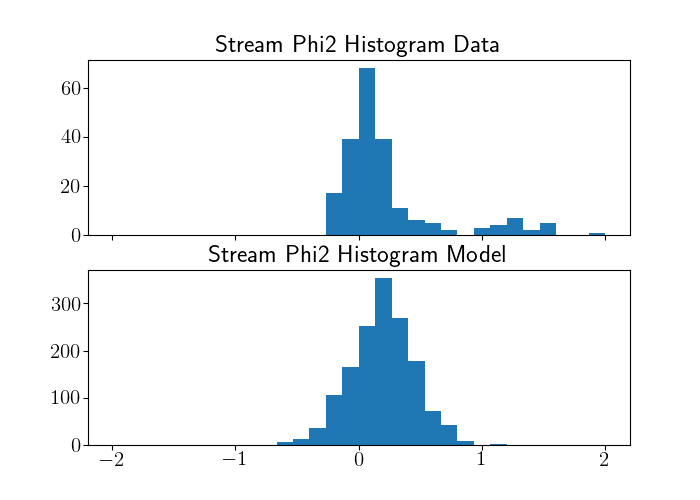

In [7]:
data_window = model_output[(model_output.phi1[:,0] > -50) & (model_output.phi1[:,0] < -25)]
gd1_window = gd1[(gd1.phi1.value > -50) & (gd1.phi1.value < -25)]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7,5), sharex = True)
ax1.hist(data_window.phi2, bins = 30, range=(-2, 2))
ax1.set_title('Stream Phi2 Histogram Data')
ax2.hist(gd1_window.phi2.value, bins = 30, range=(-2,2))
ax2.set_title('Stream Phi2 Histogram Model')
plt.show()

0
-952.5482145073338


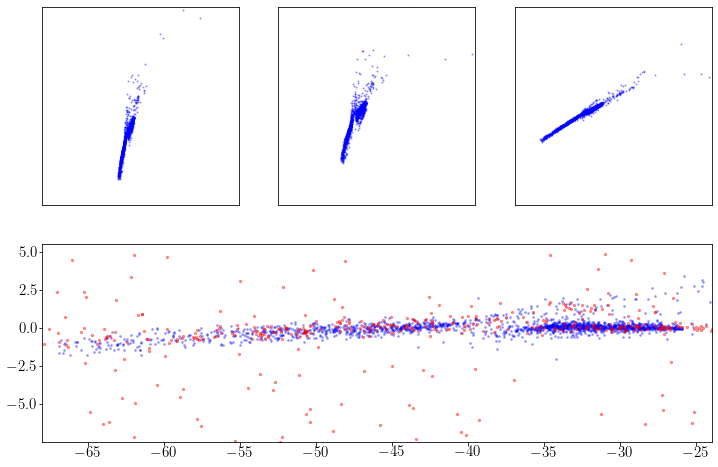

In [254]:
importlib.reload(mp)
#data = Table.read('../data/full_table0.fits')
#t10 = data[:5]

fitpert = fp.FitPert()
for i in range(1):
    print(i)
    vals = np.array([1, 355, 80, 25, 475, 6.7, 0.1])
    #vals=np.array([t10[i][0],t10[i][1],t10[i][2],t10[i][3],t10[i][4],t10[i][5],t10[i][6]])
    ll, kde_phi2, kde_pm1, kde_pm2 = fitpert.loglik_model_kde(vals)
    print(ll)
    _, orbits = fitpert.nbody()
    #mp.save_gifs(int(vals[4]), orbits, i+15)
    plots = mp.Plotting()
    plots.final_pos(orbits, i+15)
    
# 15 should be the best

In [251]:
from astropy.table import Table
data = Table.read('../data/full_table0.fits')
data = np.flip(data[data.argsort('logprob_model')])
top_data = data[:10000]

In [252]:
for i in range(len(top_data)):
    if top_data[i]['psi'] > 180:
        top_data[i]['psi'] -= 360

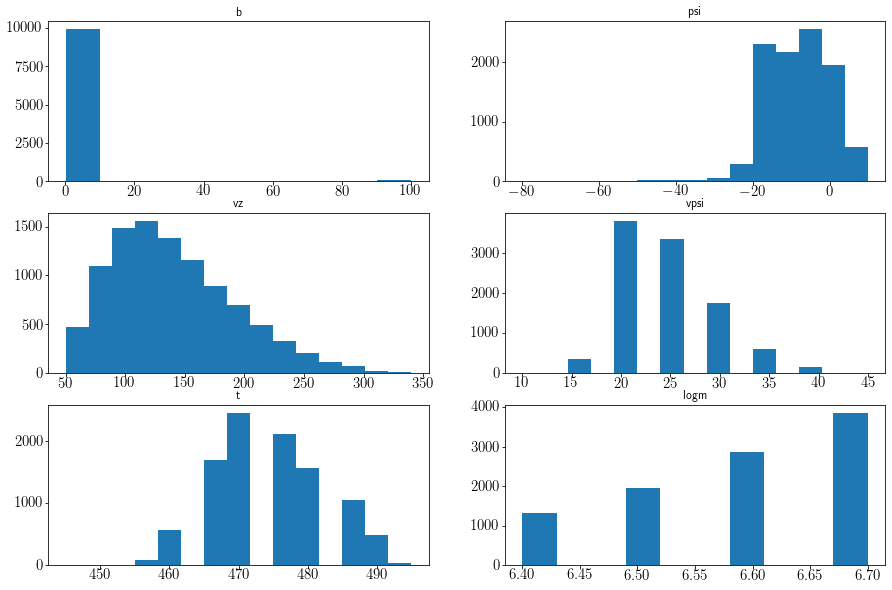

In [271]:
fig, axs = plt.subplots(3,2,figsize = (15,10))
                                                 
axs[0][0].hist(top_data['b'])
axs[0][0].set_title('b')

axs[0][1].hist(top_data['psi'], bins = 15)
axs[0][1].set_title('psi')

axs[1][0].hist(top_data['v_z'], bins=15)
axs[1][0].set_title('vz')

axs[1][1].hist(top_data['v_psi'], bins=15)
axs[1][1].set_title('vpsi')

axs[2][0].hist(top_data['t'], bins=15)
axs[2][0].set_title('t')

axs[2][1].hist(top_data['logm'], bins=10)
axs[2][1].set_title('logm')
plt.show()


In [19]:
importlib.reload(fp)

fitpert = fp.FitPert()
vals = np.array([1, 355, 80, 25, 475, 6.7, 0.1])#tbl_a[0][3:7])
ll, kde_phi2, kde_pm1, kde_pm2 = fitpert.loglik_model_kde(vals)
print(ll)

-992.2991708001837


Text(0, 0.5, 'Phi 2')

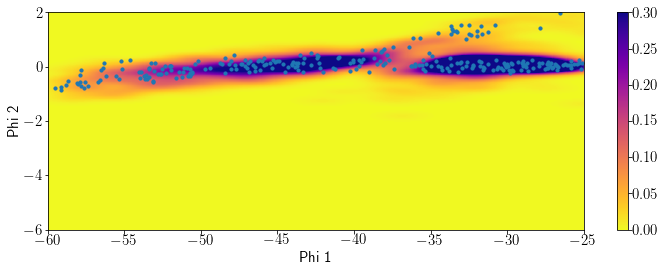

In [20]:
X, Y = np.meshgrid(np.linspace(-60, -25, 500), np.linspace(-6, 2,500))
sc = kde_phi2.score_samples(np.array([(X.flatten()+46)/10, Y.flatten()]).T).reshape(500, 500)
plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r', vmax=0.3)
plt.colorbar()
data = model_output[(model_output.phi1[:,0] > -60) & (model_output.phi1[:,0] < -25)]
plt.scatter(data.phi1, data.phi2, s=10, alpha=1)
plt.xlabel('Phi 1')
plt.ylabel('Phi 2')

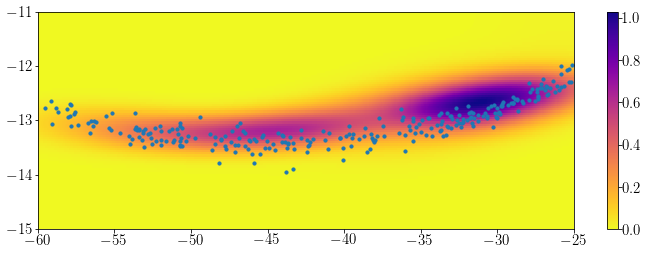

In [21]:
X, Y = np.meshgrid(np.linspace(-60, -25, 500), np.linspace(-15, -11,100))
sc = kde_pm1.score_samples(np.array([(X.flatten()+46)/15, Y.flatten()]).T).reshape(100, 500)
plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r')
plt.colorbar()
data = model_output[(model_output.phi1[:,0] > -60) & (model_output.phi1[:,0] < -25)]
plt.scatter(data.phi1, data.pm1, s=10, alpha=1)

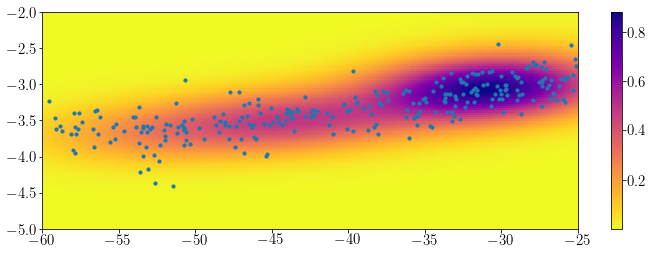

In [22]:
X, Y = np.meshgrid(np.linspace(-60, -25, 500), np.linspace(-5, -2,100))
sc = kde_pm2.score_samples(np.array([(X.flatten()+46)/15, Y.flatten()]).T).reshape(100, 500)
plt.figure(figsize=(12,4))
plt.pcolormesh(X, Y, np.e**sc, cmap='plasma_r')
plt.colorbar()
data = model_output[(model_output.phi1[:,0] > -60) & (model_output.phi1[:,0] < -25)]
plt.scatter(data.phi1, data.pm2, s=10, alpha=1)

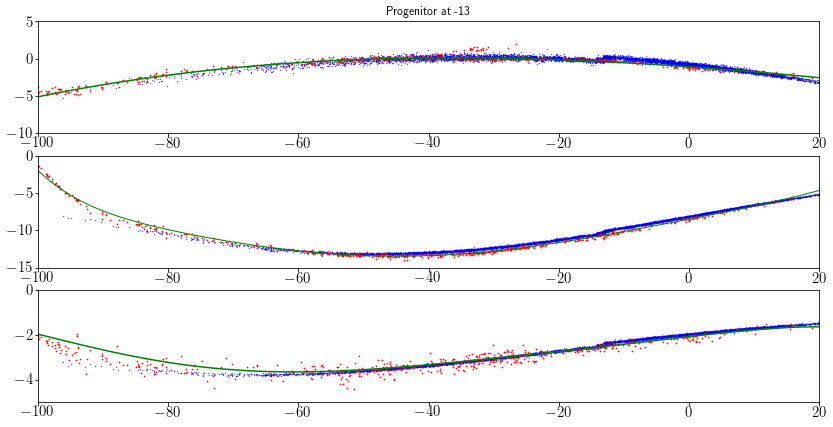

In [98]:
df = ms.FardalStreamDF(random_state=np.random.RandomState(42))
gd1_init = gc.GD1Koposov10(phi1 = -13*u.degree, phi2=0*u.degree, distance=8.90*u.kpc,
                      pm_phi1_cosphi2=-10.17*u.mas/u.yr,
                      pm_phi2=-2.425*u.mas/u.yr,
                     radial_velocity = -182*u.km/u.s)
rep = gd1_init.transform_to(coord.Galactocentric).data
gd1_w0 = gd.PhaseSpacePosition(rep)
gd1_mass = 5e3 * u.Msun
gd1_pot = gp.PlummerPotential(m=gd1_mass, b=5*u.pc, units=galactic)
mw = gp.MilkyWayPotential()
gen_gd1 = ms.MockStreamGenerator(df, mw, progenitor_potential=gd1_pot)
gd1_stream, gd1_nbody = gen_gd1.run(gd1_w0, gd1_mass,
                                dt=-1 * u.Myr, n_steps=3000)
gd1_stream_c1 = gd1_stream.to_coord_frame(gc.GD1)
gd1 = gd1_stream_c1[gd1_stream_c1.phi1.argsort()]

spline_pm10 = UnivariateSpline(gd1.phi1, gd1.pm_phi1_cosphi2, k=5)
spline_pm20 = UnivariateSpline(gd1.phi1, gd1.pm_phi2, k=5)
spline_rv = UnivariateSpline(gd1.phi1, gd1.radial_velocity)
spline_dist = UnivariateSpline(gd1.phi1, gd1.distance)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(14,7))
ax1.set_title('Progenitor at {}'.format(-13))
ax1.scatter(gd1_stream_c1.phi1.value, gd1_stream_c1.phi2.value, s=0.1, c='b')
ax1.scatter(model_output.phi1, model_output.phi2, c='r', s = 0.5)
ax1.plot(phi1s, spline_phi2(phi1s), c='g')
ax1.set_xlim(-100,20)
ax1.set_ylim(-10, 5)

ax2.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi1_cosphi2, s=0.1, c='b')
ax2.scatter(model_output.phi1, model_output.pm1, c='r', s = 0.5)
#plt.plot(gd1.phi1, spline_pm10(gd1.phi1), c='g', lw=3)
ax2.plot(phi1s, spline_pm1(phi1s), c='g', lw=1)
ax2.set_xlim(-100,20)
ax2.set_ylim(-15,0)

ax3.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi2, s=0.1, c='b')
ax3.scatter(model_output.phi1, model_output.pm2, c='r', s = 0.5)
#plt.plot(gd1.phi1, spline_pm20(gd1.phi1), c='g', lw=2)
ax3.plot(phi1s, spline_pm2(phi1s), c='g')
ax3.set_xlim(-100,20)
ax3.set_ylim(-5,0)
plt.show()

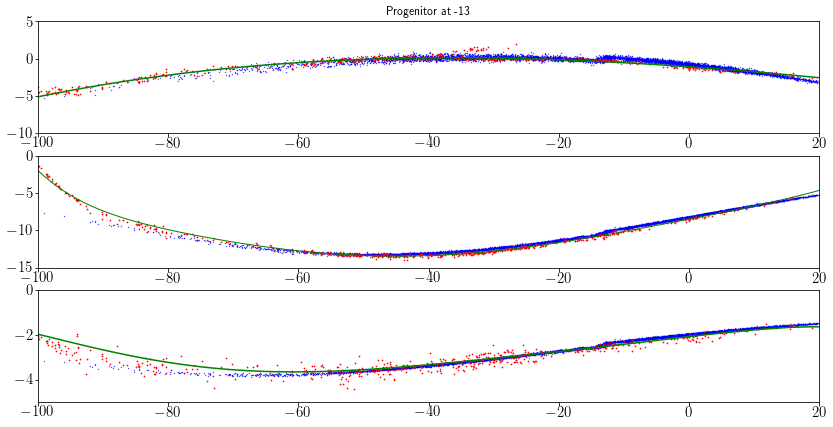

In [119]:
df = ms.FardalStreamDF(random_state=np.random.RandomState(42))
gd1_init = gc.GD1Koposov10(phi1 = -13*u.degree, phi2=0*u.degree, distance=8.88*u.kpc,
                      pm_phi1_cosphi2=-10.245*u.mas/u.yr,
                      pm_phi2=-2.429*u.mas/u.yr,
                     radial_velocity = -182.9*u.km/u.s)
rep = gd1_init.transform_to(coord.Galactocentric).data
gd1_w0 = gd.PhaseSpacePosition(rep)
gd1_mass = 5e3 * u.Msun
gd1_pot = gp.PlummerPotential(m=gd1_mass, b=5*u.pc, units=galactic)
mw = gp.MilkyWayPotential(halo={'m':5.73e11*u.Msun, 'r_s': 16*u.kpc})
gen_gd1 = ms.MockStreamGenerator(df, mw, progenitor_potential=gd1_pot)
gd1_stream, gd1_nbody = gen_gd1.run(gd1_w0, gd1_mass,
                                dt=-1 * u.Myr, n_steps=3000)
gd1_stream_c1 = gd1_stream.to_coord_frame(gc.GD1)
gd1 = gd1_stream_c1[gd1_stream_c1.phi1.argsort()]

spline_pm10 = UnivariateSpline(gd1.phi1, gd1.pm_phi1_cosphi2, k=5)
spline_pm20 = UnivariateSpline(gd1.phi1, gd1.pm_phi2, k=5)
spline_rv = UnivariateSpline(gd1.phi1, gd1.radial_velocity)
spline_dist = UnivariateSpline(gd1.phi1, gd1.distance)

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(14,7))
ax1.set_title('Progenitor at {}'.format(-13))
ax1.scatter(gd1_stream_c1.phi1.value, gd1_stream_c1.phi2.value, s=0.1, c='b')
ax1.scatter(model_output.phi1, model_output.phi2, c='r', s = 0.5)
ax1.plot(phi1s, spline_phi2(phi1s), c='g')
ax1.set_xlim(-100,20)
ax1.set_ylim(-10, 5)

ax2.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi1_cosphi2, s=0.1, c='b')
ax2.scatter(model_output.phi1, model_output.pm1, c='r', s = 0.5)
#plt.plot(gd1.phi1, spline_pm10(gd1.phi1), c='g', lw=3)
ax2.plot(phi1s, spline_pm1(phi1s), c='g', lw=1)
ax2.set_xlim(-100,20)
ax2.set_ylim(-15,0)

ax3.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi2, s=0.1, c='b')
ax3.scatter(model_output.phi1, model_output.pm2, c='r', s = 0.5)
#plt.plot(gd1.phi1, spline_pm20(gd1.phi1), c='g', lw=2)
ax3.plot(phi1s, spline_pm2(phi1s), c='g')
ax3.set_xlim(-100,20)
ax3.set_ylim(-5,0)
plt.show()

In [80]:
phi1_prog, phi2_prog, pm1_prog, pm2_prog = -13, spline_phi2(-13), spline_pm1(-13), spline_pm2(-13)
rv_prog, dm_prog = spline_rv_bon(-13), spline_dm(-13)
dist_prog = 10**((dm_prog + 5) / 5) / 1000
print(phi1_prog, phi2_prog, pm1_prog, pm2_prog, rv_prog, dist_prog)

-13 -0.38894052907512333 -10.612602580659516 -2.5198245812952007 -198.0414301828848 8.729886064821219


In [77]:
orbit = mw.integrate_orbit(w0_now, dt=-1*u.Myr, n_steps=int(300))
old_gd1 = orbit[-1]

# Converting from xyz to relative-to-stream coordinates and back again
#take the velocities of the stream particles where the pertuber will cross the stream
center = old_gd1[(np.abs(np.mean(old_gd1.pos.x.value) - old_gd1.pos.x.value) < 0.5) & 
             (np.abs(np.mean(old_gd1.pos.y.value) - old_gd1.pos.y.value) < 0.5) & 
             (np.abs(np.mean(old_gd1.pos.z.value) - old_gd1.pos.z.value) < 0.5)]

vxstream = np.mean(center.vel.d_x).to(u.km/u.s).value
vystream = np.mean(center.vel.d_y).to(u.km/u.s).value
vzstream = np.mean(center.vel.d_z).to(u.km/u.s).value

In [78]:
site_at_impact_w0 = gd.PhaseSpacePosition(pos=np.mean(old_gd1.pos),vel=[vxstream, vystream, vzstream]*u.km/u.s)
print(site_at_impact_w0)

pos=(17.02033982, -0.20371474, -9.95769503) kpc
vel=(105.80687469, 165.42390658, 41.12840051) km / s


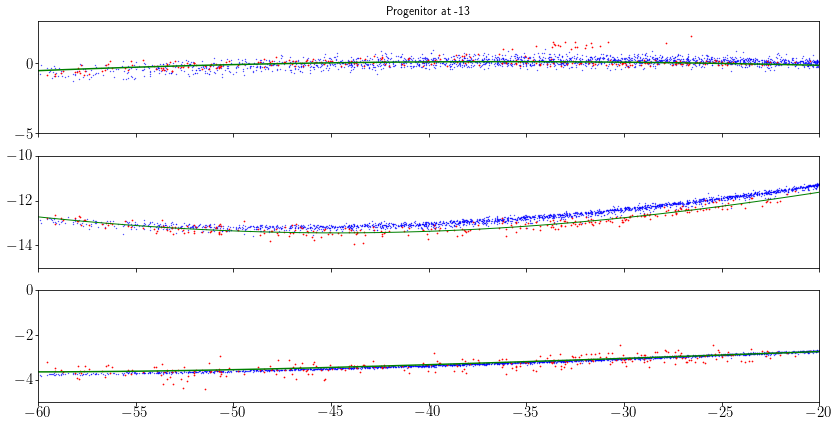

In [120]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(14,7), sharex=True)
ax1.set_title('Progenitor at {}'.format(-13))
ax1.scatter(gd1_stream_c1.phi1.value, gd1_stream_c1.phi2.value, s=0.1, c='b')
ax1.scatter(model_output.phi1, model_output.phi2, c='r', s = 0.5)
ax1.plot(phi1s, spline_phi2(phi1s), c='g')
ax1.set_xlim(-60,-20)
ax1.set_ylim(-5, 3)

ax2.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi1_cosphi2, s=0.1, c='b')
ax2.scatter(model_output.phi1, model_output.pm1, c='r', s = 0.5)
#plt.plot(gd1.phi1, spline_pm10(gd1.phi1), c='g', lw=3)
ax2.plot(phi1s, spline_pm1(phi1s), c='g', lw=1)

ax2.set_ylim(-15,-10)

ax3.scatter(gd1_stream_c1.phi1, gd1_stream_c1.pm_phi2, s=0.1, c='b')
ax3.scatter(model_output.phi1, model_output.pm2, c='r', s = 0.5)
#plt.plot(gd1.phi1, spline_pm20(gd1.phi1), c='g', lw=2)
ax3.plot(phi1s, spline_pm2(phi1s), c='g')
ax3.set_ylim(-5,0)
plt.show()

In [1]:
import sys
sys.path.append('../code/')
import fit_perturber as fp

In [150]:
%%time
import importlib
importlib.reload(fp)

PreModel = fp.FitPert()
PreModel.pre_fitting([25., 225., 320., 15., 150., 6.7, 0.5])

CPU times: user 6.94 s, sys: 463 ms, total: 7.4 s
Wall time: 7.6 s


<PhaseSpacePosition cartesian, dim=3, shape=()>

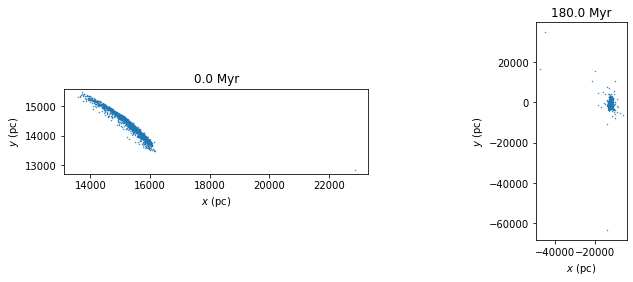

CPU times: user 6.49 s, sys: 226 ms, total: 6.71 s
Wall time: 6.9 s


In [151]:
%%time
current, orbits = PreModel.nbody()

/Users/Tavangar/anaconda3/lib/python3.7/site-packages/astropy/coordinates/baseframe.py:1215: AstropyDeprecationWarning: Transforming a frame instance to a frame class (as opposed to another frame instance) will not be supported in the future.  Either explicitly instantiate the target frame, or first convert the source frame instance to a `astropy.coordinates.SkyCoord` and use its `transform_to()` method.
  AstropyDeprecationWarning)



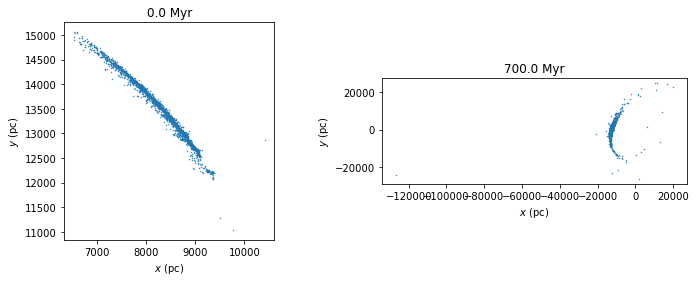

MovieWriter ffmpeg unavailable; using Pillow instead.


CPU times: user 50.2 s, sys: 2.29 s, total: 52.5 s
Wall time: 53.1 s


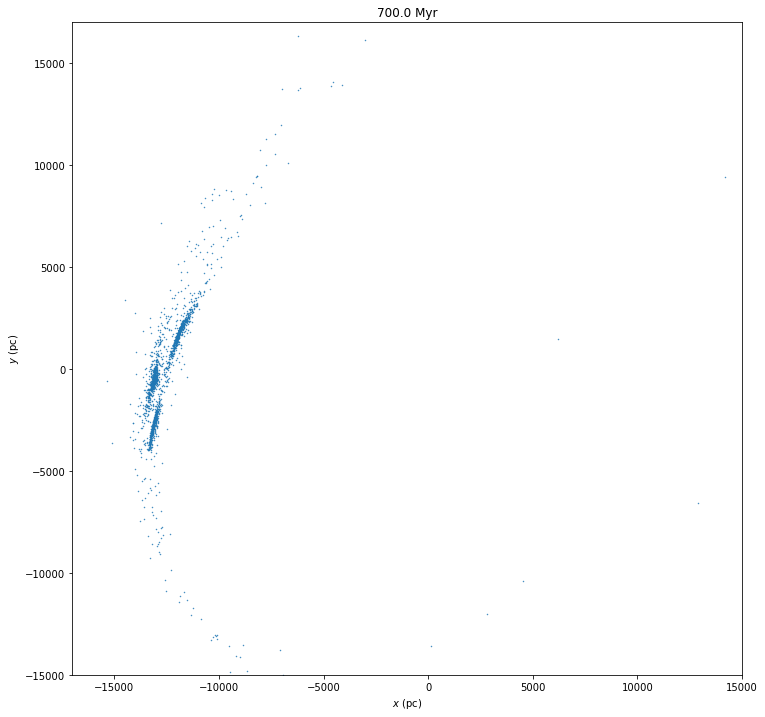

In [118]:
%%time
ll = PreModel.loglik([25., 210., 100.,  5., 670., 6.7, 0.1])

In [98]:
ll

(-4290.336305419005,
 KernelDensity(bandwidth=0.1),
 KernelDensity(bandwidth=0.06),
 KernelDensity(bandwidth=0.04))

(-90.0, 10.0)

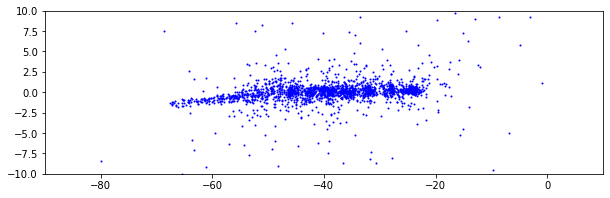

In [152]:
import gala.coordinates as gc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
#plt.scatter(orbits[-1, 1:].to_coord_frame(gc.GD1).phi1, orbits[-1, 1:].to_coord_frame(gc.GD1).phi2, s = 3, c = 'r')
plt.scatter(current.phi1, current.phi2, s = 1, c = 'b')
plt.ylim(-10, 10)
plt.xlim(-90, 10)